In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
class MLP_Tools:
    def __init__(self, data_path, label_index=-1, seed=42, method='zscore', test_size=0.2):
        self.data_path = data_path
        self.label_index = label_index
        self.seed = seed
        self.method = method
        self.test_size = test_size

        self.df = self.load_data()
        self.x, self.y = self.shuffle_and_extract()
        self.preprocessed_x = self.preprocess_features()
        self.x_train, self.y_train, self.x_test, self.y_test = self.train_test_split()

    def load_data(self):
        df = pd.read_csv(self.data_path)
        df = pd.DataFrame(df)
        return df

    def shuffle_and_extract(self):
        np.random.seed(self.seed)
        df = self.df.sample(frac=1).reset_index(drop=True)
        df.drop_duplicates(inplace=True)
        df.dropna(inplace=True)
        x = df.iloc[:, :self.label_index]
        y = df.iloc[:, self.label_index]
        return x, y

    def visualize_data(self):
        df = pd.concat([self.x, self.y], axis=1)

        sns.pairplot(df, hue=self.y.name)
        plt.suptitle('Features PairPlot', size=20)
        plt.show()

        plt.title("Correlation Matrix HeatMap")
        corr = df.corr()
        sns.heatmap(corr, annot=True, cmap='coolwarm')
        plt.show()

        for col in self.x.columns:
            sns.distplot(self.x[col], kde=False)
            plt.title(f'Distribution of {col}')
            plt.show()

    def preprocess_features(self):
        x = self.x.copy()

        if self.method == 'zscore':
            means = x.mean()
            stds = x.std()
            x = (x - means) / stds

        elif self.method == 'minmax':
            mins = x.min()
            maxs = x.max()
            x = (x - mins) / (maxs - mins)

        elif self.method == 'log':
            x = np.log1p(x)

        else:
            raise ValueError(f"Invalid scaling method: {self.method}")

        return x

    def train_test_split(self):
        split_index = int(len(self.preprocessed_x) * (1 - self.test_size))

        x_train = self.preprocessed_x[:split_index]
        x_test = self.preprocessed_x[split_index:]
        y_train = self.y[:split_index]
        y_test = self.y[split_index:]

        return x_train, y_train, x_test, y_test

In [8]:
mlp_tools = MLP_Tools('../MLP/boston.csv', method='log', test_size=0.3)
print(mlp_tools.x_train)
print(mlp_tools.y_train)
print(mlp_tools.x_test)
print(mlp_tools.y_test)

         CRIM        ZN     INDUS      CHAS       NOX        RM       AGE  \
0    0.087809  0.000000  1.619388  0.000000  0.412110  2.003640  4.443827   
1    0.054905  3.713572  2.002830  0.693147  0.369492  2.048725  3.523415   
2    0.100515  0.000000  3.358290  0.000000  0.475613  1.943479  4.603168   
3    0.087681  0.000000  2.468947  0.000000  0.345715  1.955153  2.174752   
4    1.806676  0.000000  2.949688  0.000000  0.538246  1.987463  4.530447   
..        ...       ...       ...       ...       ...       ...       ...   
349  3.137713  0.000000  2.949688  0.000000  0.553885  1.919566  4.536891   
350  1.839446  0.000000  2.949688  0.000000  0.530628  1.953169  4.424847   
351  0.206762  0.000000  2.450143  0.000000  0.398105  1.991430  3.979682   
352  0.059485  3.044522  1.465568  0.693147  0.366655  2.156981  3.925926   
353  0.047065  4.394449  1.534714  0.000000  0.330742  1.961221  3.496508   

          DIS       RAD       TAX   PTRATIO         B     LSTAT  
0    1.29

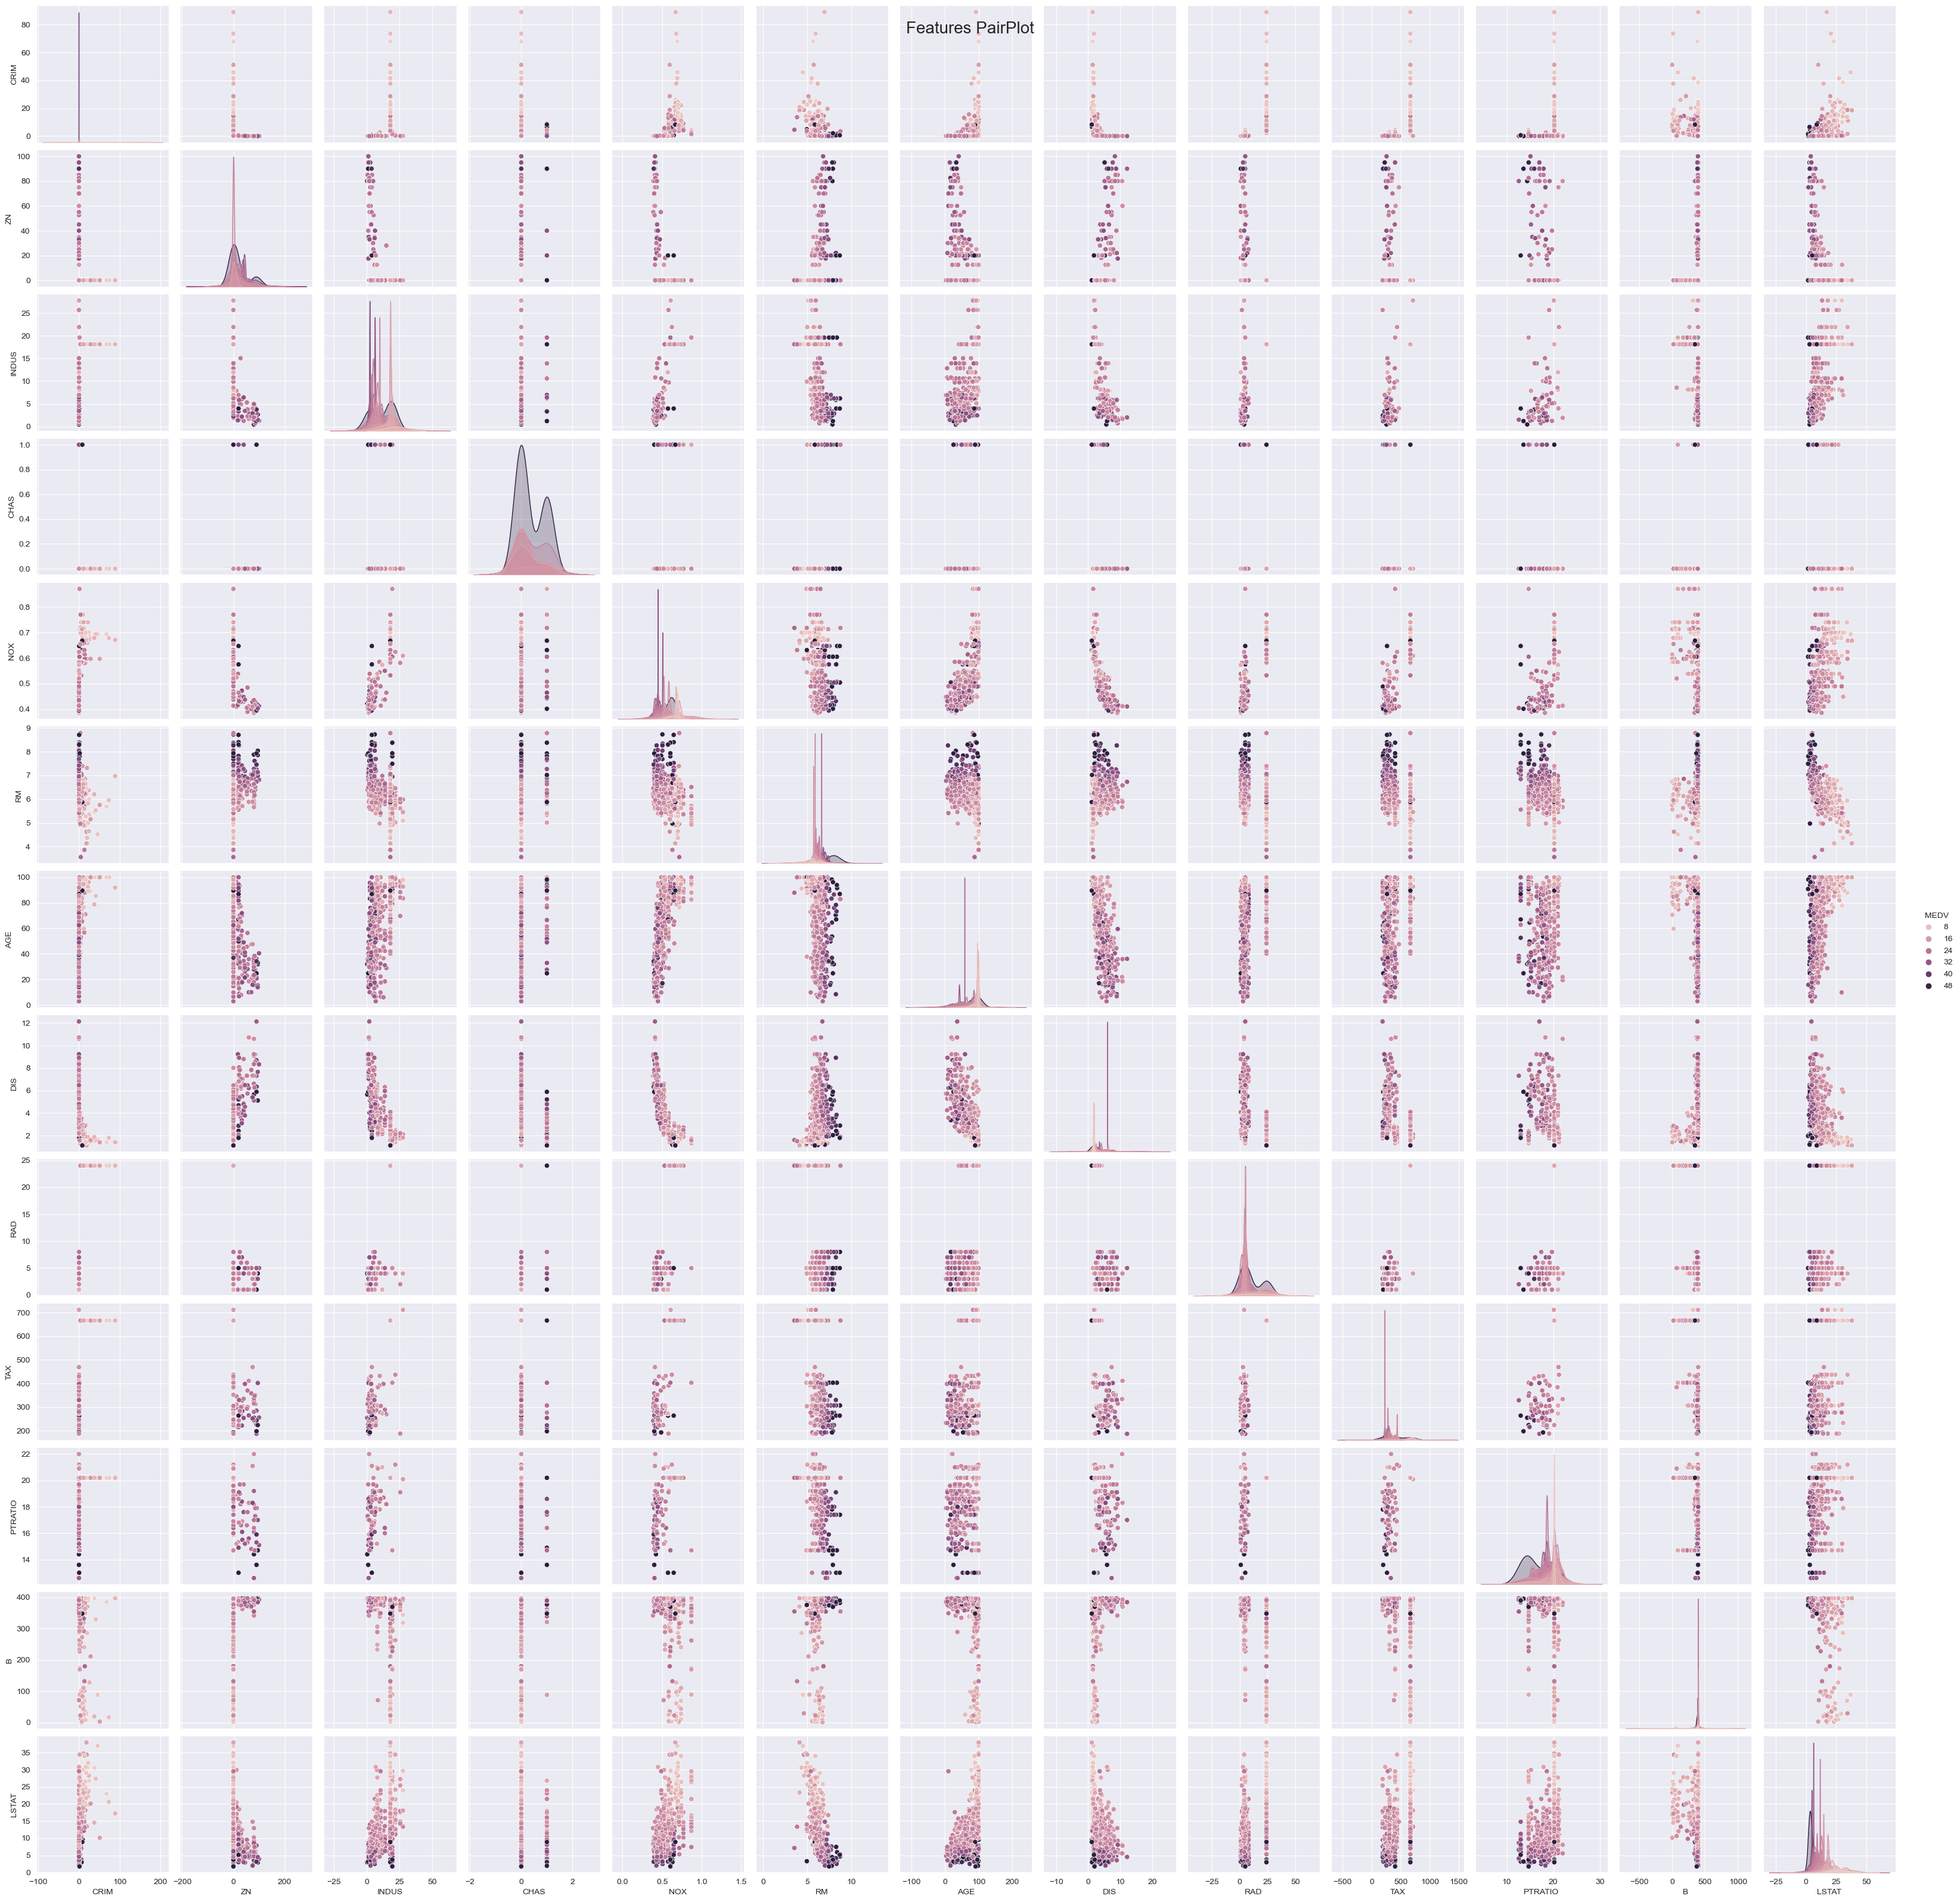

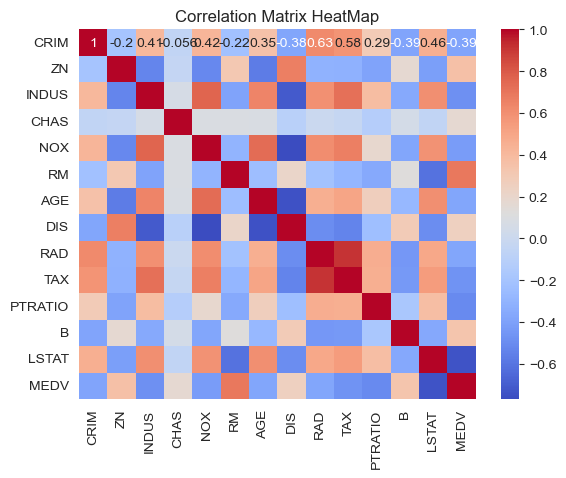

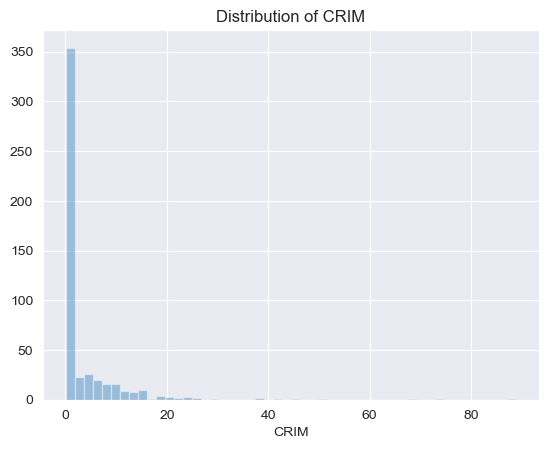

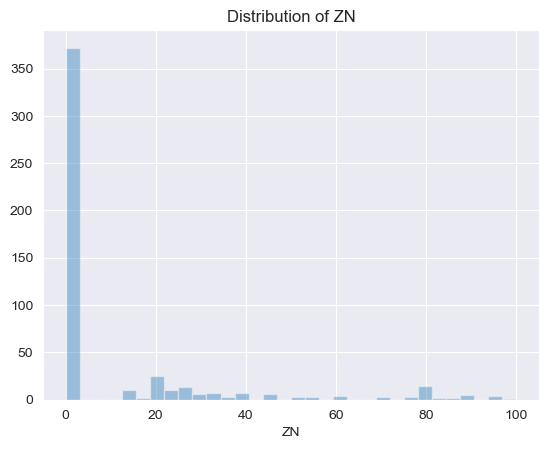

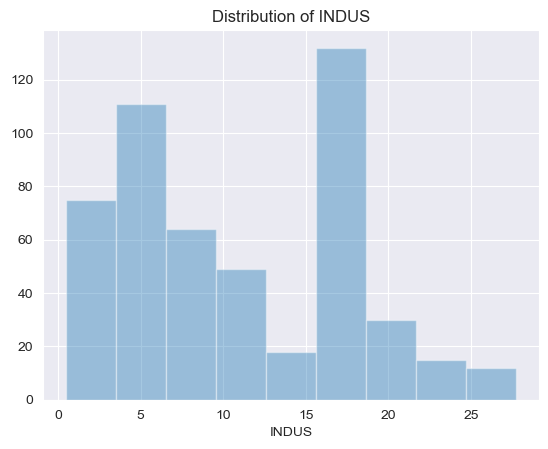

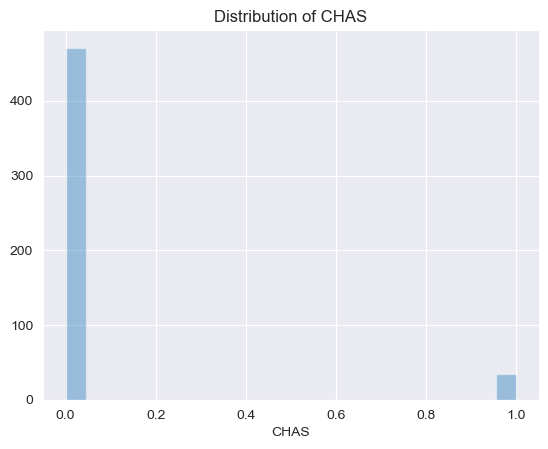

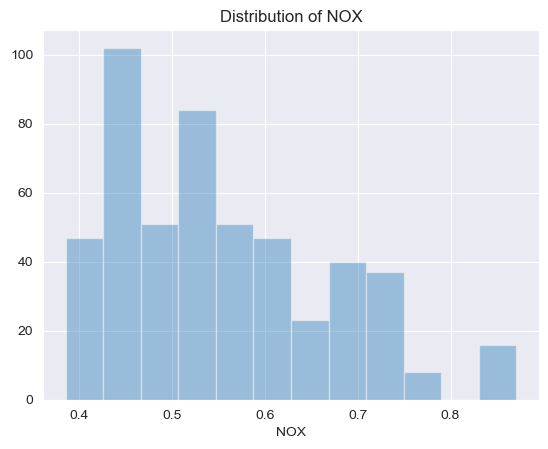

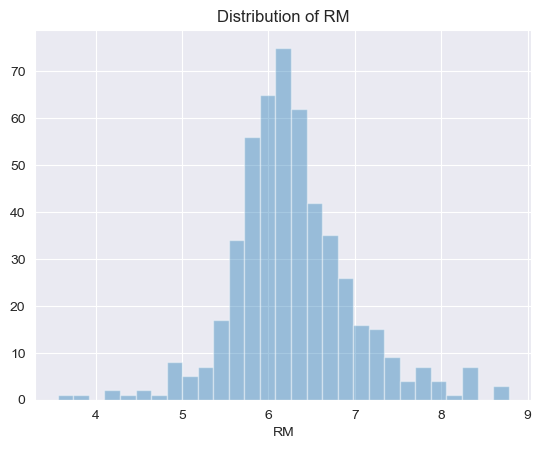

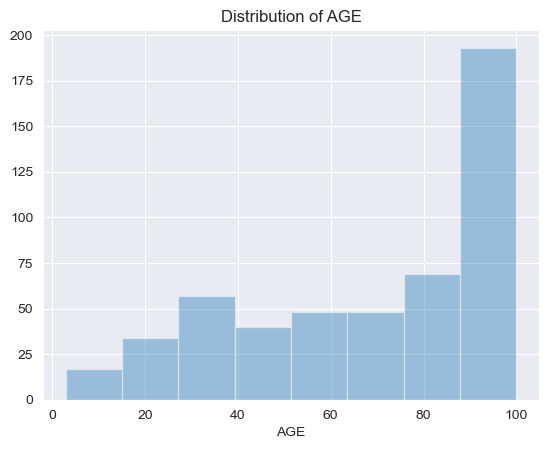

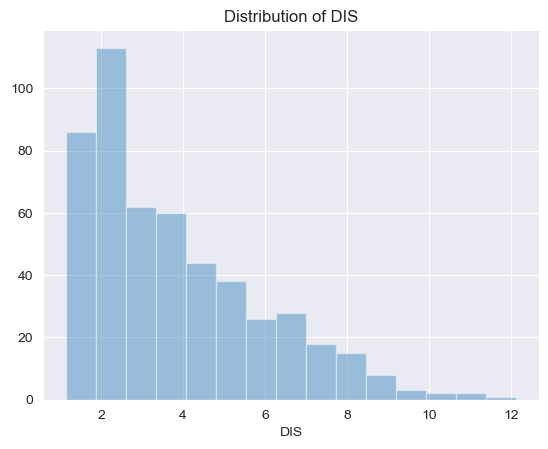

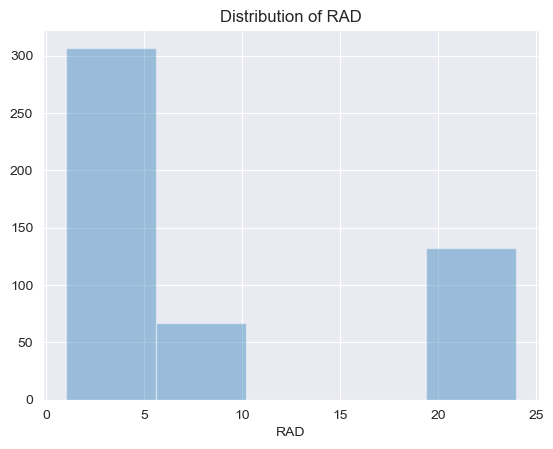

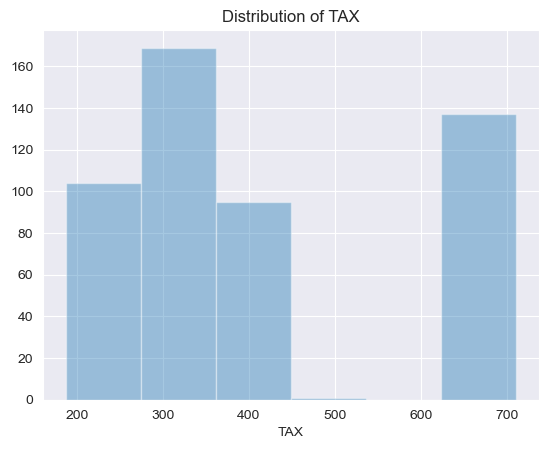

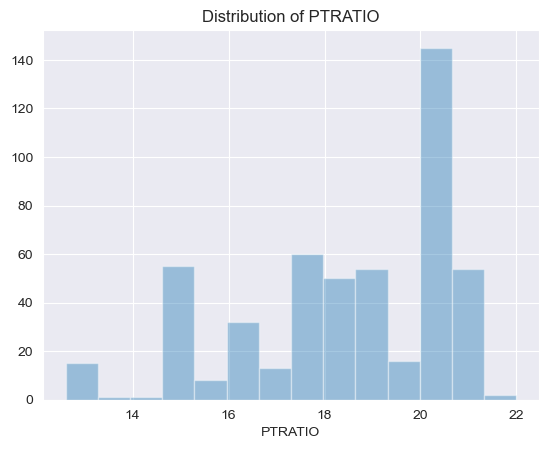

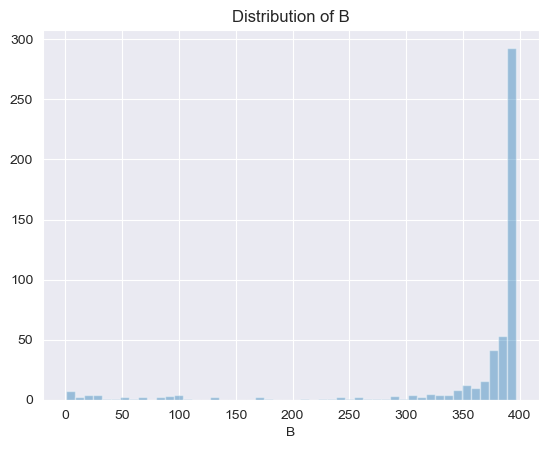

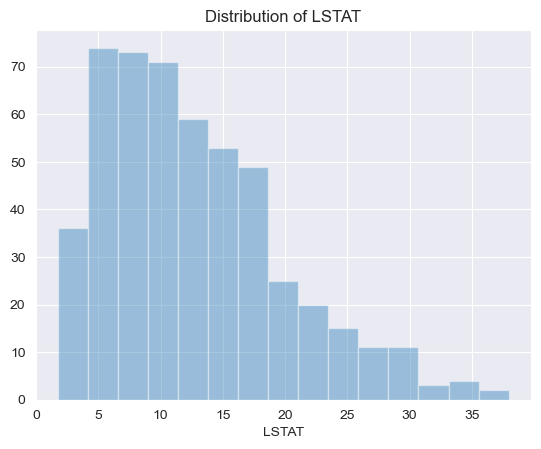

In [9]:
mlp_tools.visualize_data()

In [11]:
class MLP_Optimizer:
    def __init__(self, verbose=True):
        self.verbose = verbose
        self.clf = None

    def optimize_mlp(self, x_train, y_train, x_test, y_test):
        param_space = {
            'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
            'activation': ['tanh', 'relu'],
            'solver': ['sgd', 'adam'],
            'alpha': [0.0001, 0.05],
            'learning_rate': ['constant','adaptive'],
            'tol': np.logspace(-4, -1, 4),
            'momentum': np.linspace(0.1, 0.9, 9)
        }

        mlp = MLPRegressor(max_iter=100)

        self.clf = RandomizedSearchCV(mlp, param_space, n_jobs=-1, cv=3)

        self.clf.fit(x_train, y_train)

        if self.verbose:
            print("Best parameters found: ", self.clf.best_params_)

        y_pred = self.clf.predict(x_test)

        train_score = self.clf.score(x_train, y_train)
        if self.verbose:
            print("Training score: ", train_score)

        test_score = self.clf.score(x_test, y_test)
        if self.verbose:
            print("Test score: ", test_score)
            
        plt.figure(figsize=(12, 6))
        plt.plot(y_test, color='blue', label='Actual')
        plt.plot(y_pred, color='red', label='Predicted')
        plt.title('Actual vs Predicted')
        plt.legend()
        plt.show()

        return y_pred

Best parameters found:  {'tol': 0.0001, 'solver': 'sgd', 'momentum': 0.7000000000000001, 'learning_rate': 'constant', 'hidden_layer_sizes': (100,), 'alpha': 0.05, 'activation': 'tanh'}
Training score:  0.5994605198972964
Test score:  0.5643605562024743


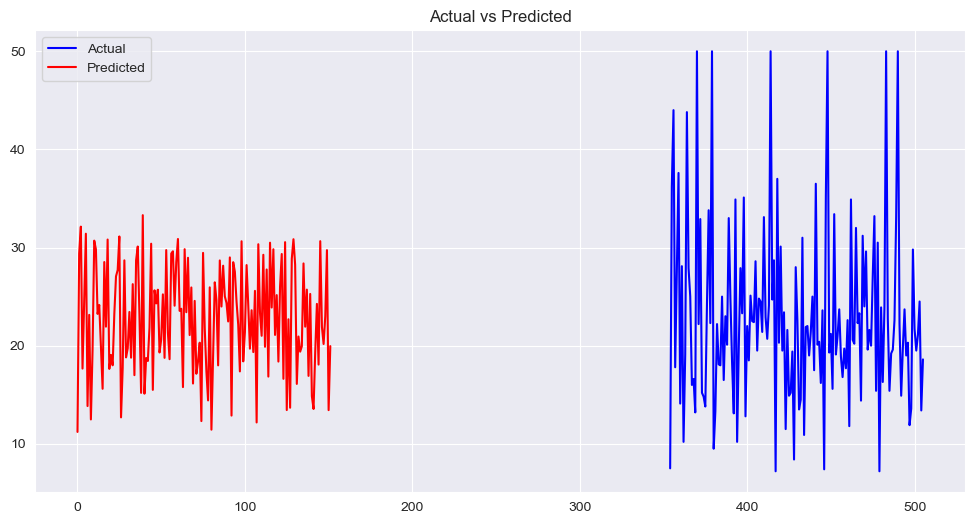

In [12]:
mlp_optimizer = MLP_Optimizer()

y_pred = mlp_optimizer.optimize_mlp(mlp_tools.x_train, mlp_tools.y_train, mlp_tools.x_test, mlp_tools.y_test)